 # PSET 3 - Part 1
 # Training a GNN to identify Synthetic Lethal (SL) gene pairs

 *Make sure you are using Colab Pro (talk to TAs about this, if needed) and train the model using a deep learning GPU (either V100 or A100).*


 **Synthetic Lethality**

*   Two genes are **synthetic lethal (SL)** if mutations in both of them reduce cell viability and/or lead to cell death, but mutations in either of them individually have minimal effects.
*   SL is particularly relevant in the context of human cancers and identifying SL gene pairs is essential for developing **anti-cancer therapeutics and drugs.**
*   There are many **biological factors (a.k.a. SL-related factors)** that can explain why a gene pair is synthetic lethal, including whether or not the two genes interact or share a molecular function, among many others. There are databases with annotated and curated information about the nature of the interaction between ~10,000 human genes, namely SL relationships ([SynLethDB Database](https://synlethdb.sist.shanghaitech.edu.cn/#/search)).
*   In this exercise, you will leverage published [work](https://academic.oup.com/bioinformatics/article/39/2/btad015/6988048) to **train a Graph Neural Network (GNN) for prediction of SL interactions. In the GNN field, this is known as "link prediction"**. This is a **supervised classification problem - either a gene pair is synthetic lethal (SL) or not** - to make predictions on human genes.


---

 **There are two complementary ways of representing data in this task**:

1.   Modeling SL interactions between gene pairs using a **SL graph** $S = (V,E)$, where nodes $V$ correspond to a set of $n$ genes and edges $E$ correspond to a SL relationship. If there is an edge between two genes, the value of the adjancency matrix $A_{1,2}$ ($R^{n \times n}$) between two genes $v_1$ and $v_2$ is 1; otherwise, it is 0.

<img src="https://drive.google.com/uc?id=1p77BmPbuHNBBsMbj2B3XqnX5stsTpSb7" width="400" height="200">


2.   Modeling the relationships between genes in a **Knowledge Graph (KG)** $G = (V_e, E_r)$, where nodes $V_e$ correspond to a set of gene entities $e$ and edges $E_r$ correspond to a set of SL-related factors/relationships $r$. Understanding what biological factors cause SL is a key part of predicting SL ([Table 2](https://academic.oup.com/bioinformatics/article/39/2/btad015/6988048)). Each KG can be represented as $G = {(h,t,r) | h,t \in V_e , r \in G_r}$. The $(h,t,r)$ triple refers to head (equivalent to nodes in the SL graph) and tail (equivalent to edges in the SL graph) entities, and relationships between heads and tails, respectively.

<img src="https://drive.google.com/uc?id=1YHuq6sRbuZrvsgoyKEyaGH21kQQAg73p" width="400" height="300">

Both graphs are input to the GNN.

---

**Why GNNs?**

Each layer in a GNN operates on graph-structured data in two steps: a **message** step and an **update** step. In this example, the message step takes information from connected nodes in the KG, and the update function transforms these parameterized messages to update the features (gene and entity embeddings) learned for each node in both the KG and SL graphs. Information from the most relevant neighboring nodes needs to be **aggregated** during message passing. Aggregated information comes from neighboring nodes and is performed over multiple iterations of message passing (a.k.a hops).

After multiple convolutional layers, each node receives a parameterized embedding. The number of layers in the neural network (NN) is chosen based on the dimensions of the graph (Figure 2 - Knowledge Graph, above). A larger number of layers allows getting information about entities that are farther way and potentially improve model performance (as long as they do not exceed the size of the graph). Complex operations are required to map all the node embeddings onto a predicted scalar value. The most important function is the **softmax function** that takes this predicted scalar value and calculates the **probability of gene pair being SL.** Information from the KG is hence used for predicting edges in the SL graph.

---

**Key aspects of the model:**

1. **Factor modeling**: Modeling different SL-related factors to reflect how they can result in an SL interaction. Factor embeddings are based on the biological relationships defined in KG (Figure 2).

2. Genes represented in the SL graph are input to the **Knowledge Graph Message Aggregation Graph Convolutional Newtwork (GCN)**, consisting of multiple layers that learn embeddings for a gene at the entity level leveraging information from the KG.

3. The **Factor-based Message Aggregation Graph Attention Network (GAN)** updates these embeddings to generate new ones using information about preferences for different SL-related factors encoded in the KG.

In both cases, embeddings are created based on features learned from neighboring nodes (hence the relevance of a graph structure!), with **each neighbor contributing differently to a relationship**. These embeddings are then used to make link predictions on SL graphs (i.e., is a gene pair SL?).

Given how in the KG, **two entities can be related through different relationships**, this model leverages attention mechanisms to understand which factors are the most relevant for a given SL interaction. Attention will be covered in detail in future lectures. All the information/context required to complete this PSET is provided here and in the questions below.

<img src="https://drive.google.com/uc?id=1430rOak_ERJyQdTOeYKBlAQWMmO38dI8" width="1000" height="200">


---

**Note**: Although there is extensive code in this exercise, you are not expected to understand every single line of it. The questions we ask in each section are meant to guide your understanding of the code. Our emphasis is on your understanding of why and how GNNs are useful in this context of predicting SL.


**Questions that require coding are highlighted throughout the PSET. Others just require you to run the relevant cells and answer the questions in the markdown cell provided at the end of the relevant code cells.**

# 1.0 Load relevant packages (~2 min)

Includes installations of relevant packages & mounting Google Drive.
A new window will pop up for you to authorize access to your Google Drive - please accept the two requests you will be presented with.

In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 53.7 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-zforo33r
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-zforo33r
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9b660ac6ca882604d1ae521912d20ded1d180ecf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.5.0-py3-none-any.whl size=10

In [ ]:
pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.0/926.0 MB 1.5 MB/s eta 0:00:00


In [ ]:
pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 38.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=6fe510809034afa7c65b2a809686dfc54c7deba1688f0e156e72f710671643c2
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc0

In [ ]:
import dgl
import dgl.function as fn
from dgl.nn import GATConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
import os
from os.path import join
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, Subset
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from time import time
from random import sample
import requests
import io
import collections
from sklearn.utils import shuffle
import networkx as nx
import torch.nn as nn
from torch_scatter import scatter_mean
from torch import optim
from code import interact
from traceback import print_tb
import torch.nn.functional as F
import json
from traceback import print_tb
from torch_scatter import scatter_mean

In [ ]:
#check if GPU is actually available
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
mydrive = '/content/drive/MyDrive'

Mounted at /content/drive


In [ ]:
#setting random see for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

#1.1 (2.5 points) Get Data to construct a Knowledge Graph (KG) (~20s)

**Run the code cells below and answer the following question.**

1. For each gene entity in the KG, 16 neighbors are being sampled in the code provided in the cells below (you should simply run them), which will be used during training. How could changing the number of sampled neighbors impact model performance?



In [ ]:
torch.set_default_dtype(torch.float32)
NEIGHBOR_NUM = 16

In [ ]:
class KGDataset(Dataset):
    def __init__(self):
        kg_dict = np.load('/content/drive/MyDrive/kg_dict.npy', allow_pickle=True).item()
        hs = np.load('/content/drive/MyDrive/hs.npy', allow_pickle=True)
        rs = np.load('/content/drive/MyDrive/rs.npy', allow_pickle=True)
        ts = np.load('/content/drive/MyDrive/ts.npy', allow_pickle=True)

        self.kg_dict = kg_dict
        self.heads = hs
        self.rels = rs
        self.tails = ts
        self.graph = None
        self.sampled_edges, self.sampled_rels = self.get_Neighborhood()

    @property
    def entity_count(self):
        return max(max(self.tails), max(self.heads)) + 2

    @property
    def relation_count(self):
        return max(self.rels) + 2

    def __len__(self):
        return len(self.kg_dict)

    def __getitem__(self, index):
        head = self.heads[index]
        relation, pos_tail = random.choice(self.kg_dict[head])
        while True:
            neg_head = random.choice(self.heads)
            neg_tail = random.choice(self.kg_dict[neg_head])[1]
            if (relation, neg_tail) in self.kg_dict[head]:
                continue
            else:
                break
        return head, relation, pos_tail, neg_tail

    def get_Neighborhood(self):
        print('sampling neighborhood...')
        neighbor_num = NEIGHBOR_NUM
        edges = np.load('/content/drive/MyDrive/sample_edges.npy', allow_pickle=True).item()
        rels = np.load('/content/drive/MyDrive/sample_rels.npy', allow_pickle=True).item()
        print('successfully loaded...')
        return edges, rels

In [ ]:
kg_dataset = KGDataset()
heads = kg_dataset.heads   #head
relations = kg_dataset.rels    #relationship
tails = kg_dataset.tails   #tail

sampling neighborhood...
successfully loaded...


YOUR ANSWER HERE

# 1.2 (5 points) Get Data to construct a SL graph & select gene pairs for training and validation (~ 5s)


**Run the code cells below and answer the following question. You will need to write some lines of code to answer Q2.**

1. What does the graph plotted below represent? What are its nodes and edges? (2.5 points)


2.   How many gene pairs are in the training and validation sets? How do these numbers compare to the total number of human genes included in the study (~10,000)? (2.5 points)







In [ ]:
class SLDataset(Dataset):
    def __init__(self, fold_n) -> None:
        super().__init__()
        print(f'loading sl dataset...')
        self.fold_n = fold_n
        self.sl_data = np.load('/content/drive/MyDrive/sl2id.npy', allow_pickle=True)
        self.df = pd.DataFrame(self.sl_data, columns=['gene_a', 'gene_b', 'label'])
        self.df = self.df[self.df['label'] == 1][['gene_a', 'gene_b']]
        self.df_reverse = pd.DataFrame()
        self.df_reverse['gene_a'] = self.df['gene_b']
        self.df_reverse['gene_b'] = self.df['gene_a']
        self.df_dataset = pd.concat([self.df, self.df_reverse])
        self.reindex_dict = self.get_reindex_dict()
        self.an_reindex_dict = {y: x for x, y in self.reindex_dict.items()}
        self.train_df, self.val_df = self.get_df()
        self.train_a, self.train_b, self.train_label, self.val_a, self.val_b, self.val_label = self.get_data()
        self.SLGraph = self.getSLGraph()

    @property
    def n_gene(self):
        return max(self.reindex_dict.values()) + 1

    @property
    def trainDataSize(self):
        return len(self.train_a)

    @property
    def valDataSize(self):
        return len(self.val_a)

    def get_df(self):
        train_df = pd.read_csv('/content/drive/MyDrive/train.txt', sep='\t')
        val_df = pd.read_csv('/content/drive/MyDrive/val.txt', sep='\t')
        train_df = self.reindex_sl(train_df)
        val_df = self.reindex_sl(val_df)
        return train_df, val_df

    def get_data(self):
        train_a = np.array(self.train_df['gene_a'])
        train_b = np.array(self.train_df['gene_b'])
        train_label = np.array(self.train_df['label'])
        val_a = np.array(self.val_df['gene_a'])
        val_b = np.array(self.val_df['gene_b'])
        val_label = np.array(self.val_df['label'])
        return train_a, train_b, train_label, val_a, val_b, val_label

    def getSLGraph(self):
        gene_a = np.array(self.train_df[self.train_df['label'] == 1]['gene_a'])
        gene_b = np.array(self.train_df[self.train_df['label'] == 1]['gene_b'])
        SLGraph = csr_matrix((np.ones(len(gene_a)), (gene_a, gene_b)), shape=(self.n_gene, self.n_gene))
        SLGraph += sp.eye(SLGraph.shape[0], format='csr')
        return SLGraph

    def getPosNeighbors(self, ids):
        posNeighbors = []
        for id in ids:
            posNeighbors.append(self.SLGraph[id].nonzero()[1])
        return posNeighbors

    def get_reindex_dict(self):
        df = self.df_dataset
        set_a = set(list(df['gene_a']))
        set_b = set(list(df['gene_b']))
        set_all = sorted(list(set_a | set_b))
        reindex_dict = dict()
        for i in range(len(set_all)):
            reindex_dict[set_all[i]] = i
        return reindex_dict

    def reindex_sl(self, df_for_reidx):
        reindex_dict = self.reindex_dict
        df = df_for_reidx.copy()
        df['gene_a'] = df['gene_a'].apply(lambda x: reindex_dict.get(x))
        df['gene_b'] = df['gene_b'].apply(lambda x: reindex_dict.get(x))
        return df

In [ ]:
sl_dataset = SLDataset(fold_n=1) #just training model on 1 fold of data (no CV)

loading sl dataset...


In [ ]:
# in this line of code you should get size of the training set
# in this line of code you should get size of the validation set

#1.3 (2.5 points) Construct SL graph (~5s)

**Run the code cells below and answer the following questions.**

1.   What are the dimensions of the binary matrix and do they make sense to you? In the context of the problem, comment on patterns you see in the matrix, namely the almost perfect yet incomplete symmetry across the diagonal as well as the sparsity of the matrix. Does its diagonal look reasonable to you?


<ipython-input-14-f6350680dbd1>:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_rows = random.sample(set(rows), subset_size)
<ipython-input-14-f6350680dbd1>:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subset_cols = random.sample(set(cols), subset_size)


Text(0.5, 1.0, 'SL Graph')

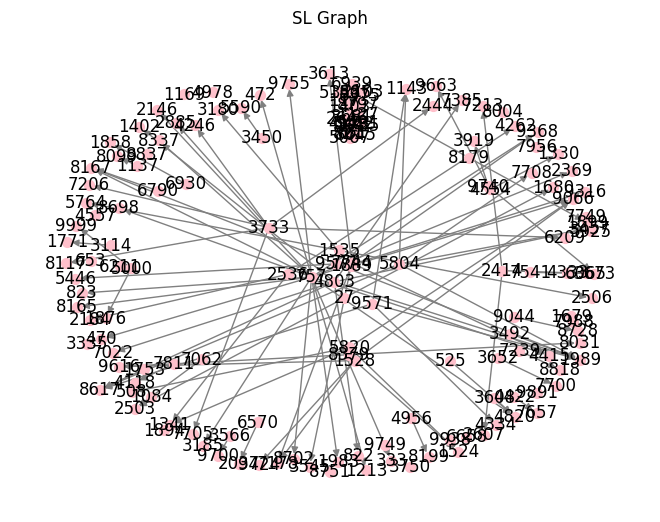

In [ ]:
from scipy.sparse import find

sparse_matrix = sl_dataset.SLGraph
rows, cols, values = find(sparse_matrix)
subset_size = int(len(set(rows)) * 0.05) #plotting only a subset of genes for visual clarity
subset_rows = random.sample(set(rows), subset_size)
subset_cols = random.sample(set(cols), subset_size)
edges = [(row, col) for row, col in zip(rows, cols) if row in subset_rows and col in subset_cols]
G = nx.DiGraph()
G.add_edges_from(edges)
G.remove_edges_from(list(nx.selfloop_edges(G)))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, node_color='pink', edge_color='gray')
plt.title('SL Graph')

(10004, 10004)


Text(0, 0.5, 'Gene b')

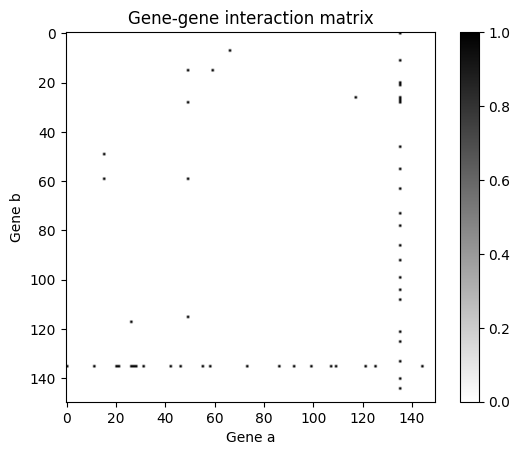

In [ ]:
dense_matrix = sparse_matrix.toarray()
np.fill_diagonal(dense_matrix, 0)
binary_matrix = (dense_matrix != 0).astype(int)
print(binary_matrix.shape)
#plotting only some genes to better visualize patterns
#can play around with what genes are shown
plt.imshow(binary_matrix[6200:6350, 6200:6350], cmap='binary')
plt.colorbar()
plt.title('Gene-gene interaction matrix')
plt.xlabel('Gene a')
plt.ylabel('Gene b')

#1.4 (5 points) Load KG Data to Construct Knowledge Graph (~30s)

**Run the code cells below and answer the following question. You will need to write some lines of code to answer Q1.**

1. How many nodes and edges does the KG have? And how many entities and relations are defined in the KG object? (2.5 points)


2.   What does the boolean variable *inverse_r* mean? How does changing it from False to True change the appearance of the KG, and the total number of edges and nodes in the KG? (2.5 points)


In [ ]:
def load_data(inverse_r):
    url = "https://github.com/zy972014452/SLGNN/raw/main/data/SL/raw/kg2id.txt"
    response = requests.get(url)
    content = response.text
    kg2id_np = np.loadtxt(content.splitlines(), dtype=np.int64)

    max = 0
    r_max = 0
    for i in range(len(kg2id_np)):
        h = kg2id_np[i][0]
        t = kg2id_np[i][2]
        r = kg2id_np[i][1]
        if h > max:
            max = h
        if t > max:
            max = t
        if r > r_max:
            r_max = r
    n_entities = max + 1
    n_relations = r_max + 1

    graph = nx.MultiDiGraph()
    for h, r, t in kg2id_np:
        graph.add_edge(h, t, key=r)
        if inverse_r == True:
            graph.add_edge(t, h, key=r + n_relations)

    return graph, n_entities, n_relations

In [ ]:
#in this line of code, call the KG graph generated in the cell above
#in this line of code, compute the number of entities in the graph
#in this line of code, compute the number of relations in the graph

YOUR ANSWER HERE

Text(0.5, 1.0, 'Knowledge Graph')

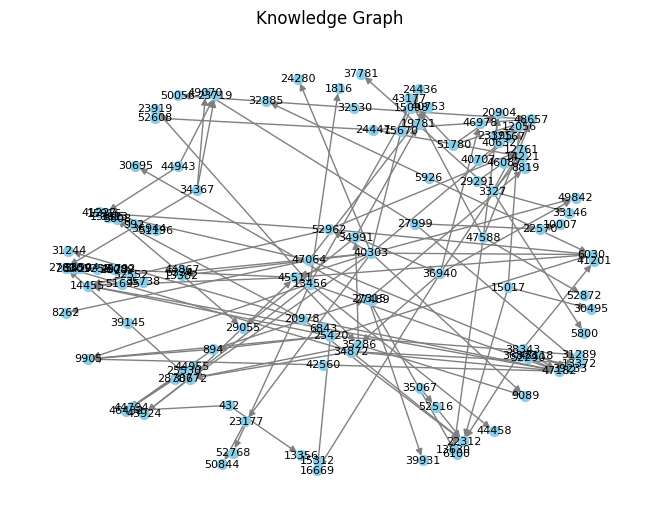

In [ ]:
#Plot the graph you loaded - plotting only 1% of data for visual clarity
nodes_subset = np.random.choice(kg_graph.nodes(), size=int(0.01 * len(kg_graph)), replace=False)
sub_graph = nx.MultiDiGraph()
sub_graph.add_nodes_from(nodes_subset)
for node in nodes_subset:
    edges = kg_graph.edges(node, keys=True, data=True)
    for edge in edges:
        if edge[1] in nodes_subset:
            sub_graph.add_edge(edge[0], edge[1], key=edge[2])

pos = nx.spring_layout(sub_graph)

#excluding nodes that are not connected by edges
sub_graph_all = sub_graph.to_undirected()
components = list(nx.connected_components(sub_graph_all))
largest_component = max(components, key=len)
final_sub_graph = sub_graph.subgraph(largest_component)
nx.draw(final_sub_graph, pos, with_labels=True, node_size=50, node_color='skyblue',  edge_color='gray', font_size=8)
plt.title("Knowledge Graph")

# 1.5 (5 points) Create Datasets and Dataloaders for Training & Validation (~1s)

**Run the code cells below and answer the following question. You will need to write some lines of code to answer this question.**

1.   Create dataloaders for the training and validation datasets.


In [ ]:
#Define Model Hyperparameters

class ArgsConfig:
    def __init__(self):

        #training parameters
        self.epoch = 100
        self.batch_size = 5000
        self.dim = 64
        self.lr = 3e-3

        #regularization parameters (prevent overfitting)
        self.l2 = 1e-4
        self.sim_regularity = 1e-3
        self.node_dropout = True
        self.node_dropout_rate = 0.5
        self.mess_dropout = True
        self.mess_dropout_rate = 0.1

        #other relevant parameters for the GNN
        self.context_hops = 3
        self.n_factors = 4
        self.ind = 'distance'

        self.cuda = True #Change depending on running on GPU/CPU
        self.gpu_id = 0
        self.fold_n = 1
        self.inverse_r = False


args_config = ArgsConfig()

In [ ]:
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        gene_a = np.array(self.df.iloc[idx]['gene_a'])
        gene_b = np.array(self.df.iloc[idx]['gene_b'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return gene_a, gene_b, label

In [ ]:
#in this line of code, call the training set defined in the KGCNDataset
#in this line of code create, create the DataLoader for the training set

#in this line of code, call the validation set defined in the KGCNDataset
#in this line of code create, create the DataLoader for the validation set

#1.6 Model Architecture (~10s)

**Note**:  Despite the extensive code shown below, you are not expected to understand every single line of it. The questions in each section are meant to guide your understanding of the code. Our emphasis is on your understanding of why and how GNNs are useful in the context of predicting SL.

-----

This model includes 3 classes: **Graph Attention Network (GAT) Class**, **Aggregator Class**, and **GraphConv Class**. The final model that calls all classes is named **SLModel.**

**Run the code cells below.**


#1.6.1 Graph Attention Network (GAT) Class

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#function required by model classes

def DistanceCorrelation(tensor_1, tensor_2):
    # tensor_1, tensor_2: [channel]
    # ref: https://en.wikipedia.org/wiki/Distance_correlation
    channel = tensor_1.shape[0]
    zeros = torch.zeros(channel, channel).to(tensor_1.device)
    zero = torch.zeros(1).to(tensor_1.device)
    tensor_1, tensor_2 = tensor_1.unsqueeze(-1), tensor_2.unsqueeze(-1)
    """cul distance matrix"""
    a_, b_ = torch.matmul(tensor_1, tensor_1.t()) * 2, \
           torch.matmul(tensor_2, tensor_2.t()) * 2  # [channel, channel]
    tensor_1_square, tensor_2_square = tensor_1**2, tensor_2**2
    a, b = torch.sqrt(torch.max(tensor_1_square - a_ + tensor_1_square.t(), zeros) + 1e-8), \
           torch.sqrt(torch.max(tensor_2_square - b_ + tensor_2_square.t(), zeros) + 1e-8)  # [channel, channel]
    """cul distance correlation"""
    A = a - a.mean(dim=0, keepdim=True) - a.mean(dim=1,
                                                 keepdim=True) + a.mean()
    B = b - b.mean(dim=0, keepdim=True) - b.mean(dim=1,
                                                 keepdim=True) + b.mean()
    dcov_AB = torch.sqrt(torch.max((A * B).sum() / channel**2, zero) + 1e-8)
    dcov_AA = torch.sqrt(torch.max((A * A).sum() / channel**2, zero) + 1e-8)
    dcov_BB = torch.sqrt(torch.max((B * B).sum() / channel**2, zero) + 1e-8)
    return dcov_AB / torch.sqrt(dcov_AA * dcov_BB + 1e-8)

In [ ]:
class GAT(nn.Module):
    def __init__(self, num_layers, in_dim, num_hidden, num_classes, heads,
                 activation, feat_drop, attn_drop, negative_slope, residual):

        super(GAT, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = activation

        # input projection (no residual)
        self.gat_layers.append(
            GATConv(in_dim, num_hidden, heads[0], feat_drop, attn_drop,
                    negative_slope, False, self.activation))

        # hidden layers
        for l in range(1, num_layers):
            self.gat_layers.append(
                GATConv(num_hidden * heads[l - 1], num_hidden, heads[l],
                        feat_drop, attn_drop, negative_slope, residual,
                        self.activation))

        # output projection
        self.gat_layers.append(
            GATConv(num_hidden * heads[-2], num_classes, heads[-1], feat_drop,
                    attn_drop, negative_slope, residual, None))

    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h).flatten(1)
        # output projection
        logits = self.gat_layers[-1](g, h).mean(1)
        return logits

#1.6.2  Aggregator Class




In [ ]:
class Aggregator(nn.Module):
    """
    Relational Path-aware Convolution Network
    """
    def __init__(self, n_genes, n_factors, reindex_dict):
        super(Aggregator, self).__init__()
        self.n_genes = n_genes
        self.n_factors = n_factors
        self.reindex_dict = reindex_dict


    def forward(self, GATConv, sl_graph, entity_emb, gene_sl_emb, latent_emb,
                edge_index, edge_type, interact_mat, weight, disen_weight_att):

        n_entities = entity_emb.shape[0]
        channel = entity_emb.shape[1]
        n_genes = self.n_genes
        n_factors = self.n_factors

        """KG aggregate"""
        head, tail = edge_index
        edge_relation_emb = weight[edge_type]
        neigh_relation_emb = entity_emb[tail] * edge_relation_emb
        entity_agg = scatter_mean(src=neigh_relation_emb, index=head, dim_size=n_entities, dim=0)
        #The scatter_mean function is the one that accounts for message aggregation from neighboring nodes

        latent_emb = torch.mm(nn.Softmax(dim=-1)(disen_weight_att), weight)
        score_ = torch.mm(gene_sl_emb, latent_emb.t())
        score = nn.Softmax(dim=1)(score_).unsqueeze(-1)

        gene_list = [i for i in range(self.n_genes)]
        reidx_dict = dict([(key, self.reindex_dict[key]) for key in gene_list])
        reidx = torch.tensor(list(reidx_dict.values()))
        gene_agg = torch.sparse.mm(interact_mat, entity_emb[reidx])
        output_sl = []
        input_emb = entity_agg[reidx]

        for i in range(self.n_factors):
            output_emb = GATConv[i](sl_graph, input_emb)
            output_emb_i = output_emb * latent_emb[i]
            output_sl.append(output_emb_i)

        output_sl = torch.stack(output_sl)
        output_sl = output_sl.permute(1, 0, 2)
        disen_weight = torch.mm(nn.Softmax(dim=-1)(disen_weight_att),
                                weight).expand(n_genes, n_factors, channel)

        gene_return = gene_agg + (output_sl * score).sum(dim=1)
        return entity_agg, gene_return, output_sl

#1.6.3 GraphConv Class


In [ ]:
class GraphConv(nn.Module):
    """
    Graph Convolutional Network
    """
    def __init__(self,
                 channel,
                 n_hops,
                 n_genes,
                 n_factors,
                 n_relations,
                 interact_mat,
                 ind,
                 reindex_dict,
                 node_dropout_rate=0.5,
                 mess_dropout_rate=0.1):
        super(GraphConv, self).__init__()
        self.GATConv = nn.ModuleList()
        self.convs = nn.ModuleList()
        self.interact_mat = interact_mat
        self.sl_graph = self.get_sl_graph()
        self.n_relations = n_relations
        self.n_genes = n_genes
        self.n_factors = n_factors
        self.reindex_dict = reindex_dict
        self.node_dropout_rate = node_dropout_rate
        self.mess_dropout_rate = mess_dropout_rate
        self.ind = ind
        for i in range(self.n_factors):
            self.GATConv.append(
                GAT(1, channel, channel, channel, [8, 8], F.leaky_relu, 0.2,
                    0.2, 0.2, True))
        self.temperature = 0.2
        initializer = nn.init.xavier_uniform_
        weight = initializer(torch.empty(n_relations, channel))
        self.weight = nn.Parameter(weight)

        disen_weight_att = initializer(torch.empty(n_factors, n_relations))
        self.disen_weight_att = nn.Parameter(disen_weight_att)

        for i in range(n_hops):
            self.convs.append(
                Aggregator(n_genes=n_genes,
                           n_factors=n_factors,
                           reindex_dict=self.reindex_dict))

        self.dropout = nn.Dropout(p=mess_dropout_rate)  # mess dropout

    def get_sl_graph(self):
        interact_mat = self.interact_mat
        indices = interact_mat._indices()
        g = dgl.graph((indices[0], indices[1]))
        return g.to(device)

    def _edge_sampling(self, edge_index, edge_type, rate=0.5):
        # edge_index: [2, -1]
        # edge_type: [-1]
        n_edges = edge_index.shape[1]
        random_indices = np.random.choice(n_edges,
                                          size=int(n_edges * rate),
                                          replace=False)
        return edge_index[:, random_indices], edge_type[random_indices]

    def _sparse_dropout(self, x, rate=0.5):
        noise_shape = x._nnz()  #number of none zeros
        #稀疏tensor的dropout
        random_tensor = rate
        random_tensor += torch.rand(noise_shape).to(x.device)
        dropout_mask = torch.floor(random_tensor).type(torch.bool)
        i = x._indices()
        v = x._values()

        i = i[:, dropout_mask]
        v = v[dropout_mask]

        out = torch.sparse.FloatTensor(i, v, x.shape).to(x.device)
        return out * (1. / (1 - rate))

    # def _cul_cor_pro(self):
    #     # disen_T: [num_factor, dimension]
    #     disen_T = self.disen_weight_att.t()
    #
    #     # normalized_disen_T: [num_factor, dimension]
    #     normalized_disen_T = disen_T / disen_T.norm(dim=1, keepdim=True)
    #
    #     pos_scores = torch.sum(normalized_disen_T * normalized_disen_T, dim=1)
    #     ttl_scores = torch.sum(torch.mm(disen_T, self.disen_weight_att), dim=1)
    #
    #     pos_scores = torch.exp(pos_scores / self.temperature)
    #     ttl_scores = torch.exp(ttl_scores / self.temperature)
    #
    #     mi_score = - torch.sum(torch.log(pos_scores / ttl_scores))
    #     return mi_score

    def _cul_cor(self):
        def CosineSimilarity(tensor_1, tensor_2):
            # tensor_1, tensor_2: [channel]
            normalized_tensor_1 = tensor_1 / tensor_1.norm(dim=0, keepdim=True)
            normalized_tensor_2 = tensor_2 / tensor_2.norm(dim=0, keepdim=True)
            return (normalized_tensor_1 *
                    normalized_tensor_2).sum(dim=0)**2  # no negative

        def DistanceCorrelation(tensor_1, tensor_2):
            # tensor_1, tensor_2: [channel]
            # ref: https://en.wikipedia.org/wiki/Distance_correlation
            channel = tensor_1.shape[0]
            zeros = torch.zeros(channel, channel).to(tensor_1.device)
            zero = torch.zeros(1).to(tensor_1.device)
            tensor_1, tensor_2 = tensor_1.unsqueeze(-1), tensor_2.unsqueeze(-1)
            """cul distance matrix"""
            a_, b_ = torch.matmul(tensor_1, tensor_1.t()) * 2, \
                   torch.matmul(tensor_2, tensor_2.t()) * 2  # [channel, channel]
            tensor_1_square, tensor_2_square = tensor_1**2, tensor_2**2
            a, b = torch.sqrt(torch.max(tensor_1_square - a_ + tensor_1_square.t(), zeros) + 1e-8), \
                   torch.sqrt(torch.max(tensor_2_square - b_ + tensor_2_square.t(), zeros) + 1e-8)  # [channel, channel]
            """cul distance correlation"""
            A = a - a.mean(dim=0, keepdim=True) - a.mean(
                dim=1, keepdim=True) + a.mean()
            B = b - b.mean(dim=0, keepdim=True) - b.mean(
                dim=1, keepdim=True) + b.mean()
            dcov_AB = torch.sqrt(
                torch.max((A * B).sum() / channel**2, zero) + 1e-8)
            dcov_AA = torch.sqrt(
                torch.max((A * A).sum() / channel**2, zero) + 1e-8)
            dcov_BB = torch.sqrt(
                torch.max((B * B).sum() / channel**2, zero) + 1e-8)
            return dcov_AB / torch.sqrt(dcov_AA * dcov_BB + 1e-8)

        def MutualInformation():
            # disen_T: [num_factor, dimension]
            disen_T = self.disen_weight_att.t()

            # normalized_disen_T: [num_factor, dimension]
            normalized_disen_T = disen_T / disen_T.norm(dim=1, keepdim=True)

            pos_scores = torch.sum(normalized_disen_T * normalized_disen_T,
                                   dim=1)
            ttl_scores = torch.sum(torch.mm(disen_T, self.disen_weight_att),
                                   dim=1)

            pos_scores = torch.exp(pos_scores / self.temperature)
            ttl_scores = torch.exp(ttl_scores / self.temperature)

            mi_score = -torch.sum(torch.log(pos_scores / ttl_scores))
            return mi_score

        """cul similarity for each latent factor weight pairs"""
        if self.ind == 'mi':
            return MutualInformation()
        else:
            cor = 0
            for i in range(self.n_factors):
                for j in range(i + 1, self.n_factors):
                    if self.ind == 'distance':
                        cor += DistanceCorrelation(self.disen_weight_att[i],
                                                   self.disen_weight_att[j])
                    else:
                        cor += CosineSimilarity(self.disen_weight_att[i],
                                                self.disen_weight_att[j])
        return cor

    def forward(self,
                gene_emb,
                entity_emb,
                latent_emb,
                edge_index,
                edge_type,
                interact_mat,
                mess_dropout=True,
                node_dropout=False):
        """node dropout"""
        if node_dropout:
            edge_index, edge_type = self._edge_sampling(
                edge_index, edge_type, self.node_dropout_rate)
            interact_mat = self._sparse_dropout(interact_mat,
                                                self.node_dropout_rate)

        entity_res_emb = entity_emb  # [n_entity, channel]
        gene_res_emb = gene_emb  #[n_gene, channel]
        cor = self._cul_cor()
        for_reg = None
        for i in range(len(self.convs)):
            entity_emb, gene_emb, output_gene = self.convs[i](
                self.GATConv, self.sl_graph, entity_emb, gene_emb, latent_emb,
                edge_index, edge_type, interact_mat, self.weight,
                self.disen_weight_att)
            """message dropout"""
            for_reg = output_gene.mean(dim=0)
            if mess_dropout:
                entity_emb = self.dropout(entity_emb)
                gene_emb = self.dropout(gene_emb)
            entity_emb = F.normalize(entity_emb)
            gene_emb = F.normalize(gene_emb)
            """result emb"""
            entity_res_emb = torch.add(entity_res_emb, entity_emb)
            gene_res_emb = torch.add(gene_res_emb, gene_emb)
            if i == 0:
                for_reg = output_gene.mean(dim=0)
            else:
                for_reg = torch.add(for_reg, output_gene.mean(dim=0))

        cor_2 = 0

        for i in range(self.n_factors):
            for j in range(i + 1, self.n_factors):
                cor_2 += DistanceCorrelation(for_reg[i], for_reg[j])

        return entity_res_emb, gene_res_emb, cor, cor_2

#1.6.4 (10 points) Define SLModel

**Run the code cells below. You will need to write some lines of code to answer this question.**

Instantiate the model, load the model on the GPU, and define the appropriate loss function and Adam optimizer with the model parameters and learning rate.


In [ ]:
class SLModel(nn.Module):
    def __init__(self, n_genes, n_relations, n_entities, args_config, kg, sl_adj, reindex_dict):
        super(SLModel, self).__init__()
        self.n_genes = n_genes
        self.n_relations = n_relations
        self.reindex_dict = {y: x for x, y in reindex_dict.items()}
        self.n_entities = n_entities
        self.decay = args_config.l2
        self.sim_decay = args_config.sim_regularity
        self.emb_size = args_config.dim
        self.context_hops = args_config.context_hops
        self.n_factors = args_config.n_factors
        self.node_dropout = args_config.node_dropout
        self.node_dropout_rate = args_config.node_dropout_rate
        self.mess_dropout = args_config.mess_dropout
        self.mess_dropout_rate = args_config.mess_dropout_rate
        self.ind = args_config.ind
        self.device = torch.device("cuda:" + str(args_config.gpu_id)) if args_config.cuda \
                                                                      else torch.device("cpu")
        self.sl_adj = sl_adj
        self.kg = kg
        self.edge_index, self.edge_type = self._get_edges(kg)

        self._init_weight()
        self.all_embed = nn.Parameter(self.all_embed)
        self.latent_emb = nn.Parameter(self.latent_emb)

        self.gcn = self._init_model()

    def _init_weight(self):
        initializer = nn.init.xavier_uniform_
        self.all_embed = initializer(
            torch.empty(self.n_genes + self.n_entities, self.emb_size))
        self.latent_emb = initializer(
            torch.empty(self.n_factors, self.emb_size))
        self.interact_mat = self._convert_sp_mat_to_sp_tensor(self.sl_adj).to(
            self.device)

    def _init_model(self):
        return GraphConv(channel=self.emb_size,
                         n_hops=self.context_hops,
                         n_genes=self.n_genes,
                         n_relations=self.n_relations,
                         n_factors=self.n_factors,
                         interact_mat=self.interact_mat,
                         ind=self.ind,
                         reindex_dict=self.reindex_dict,
                         node_dropout_rate=self.node_dropout_rate,
                         mess_dropout_rate=self.mess_dropout_rate)

    def _convert_sp_mat_to_sp_tensor(self, X):
        coo = X.tocoo()
        i = torch.LongTensor(np.array([coo.row, coo.col]))
        v = torch.from_numpy(coo.data).float()
        return torch.sparse.FloatTensor(i, v, coo.shape)

    def _get_indices(self, X):
        coo = X.tocoo()
        return torch.LongTensor([coo.row, coo.col]).t()

    def _get_edges(self, graph):
        graph_tensor = torch.tensor(list(graph.edges))
        index = graph_tensor[:, :-1]
        type = graph_tensor[:, -1]
        return index.t().long().to(self.device), type.long().to(self.device)

    #takes input data (a pair of genes) and returns output of sigmoid function and losses
    def forward(self, gene_a, gene_b):
        gene_emb = self.all_embed[:self.n_genes, :]
        item_emb = self.all_embed[self.n_genes:, :]

        entity_gcn_emb, gene_gcn_emb, cor, cor_2 = self.gcn(
            gene_emb,
            item_emb,
            self.latent_emb,
            self.edge_index,
            self.edge_type,
            self.interact_mat,
            mess_dropout=self.mess_dropout,
            node_dropout=self.node_dropout)
        e_u = gene_gcn_emb[gene_a]
        reidx_dict = dict([(key, self.reindex_dict[int(key)])
                           for key in gene_b])
        e_e = entity_gcn_emb[torch.tensor(list(reidx_dict.values()))]

        scores = (e_u * e_e).sum(dim=1)
        regularizer = (torch.norm(e_u)**2 + torch.norm(e_e)**2) / 2
        emb_loss = self.decay * regularizer / len(gene_a)
        cor_loss = self.sim_decay * (cor + cor_2)

        return torch.sigmoid(scores), emb_loss, cor_loss, cor

    def generate(self):
        gene_emb = self.all_embed[:self.n_genes, :]
        item_emb = self.all_embed[self.n_genes:, :]
        return self.gcn(gene_emb,
                        item_emb,
                        self.latent_emb,
                        self.edge_index,
                        self.edge_type,
                        self.interact_mat,
                        mess_dropout=False,
                        node_dropout=False)[:-1]

    def rating(self, u_g_embeddings, i_g_embeddings):
        return torch.matmul(u_g_embeddings, i_g_embeddings.t())

    def create_bpr_loss(self, genes, pos_items, neg_items, cor):
        batch_size = genes.shape[0]
        pos_scores = torch.sum(torch.mul(genes, pos_items), axis=1)
        neg_scores = torch.sum(torch.mul(genes, neg_items), axis=1)

        mf_loss = -1 * torch.mean(nn.LogSigmoid()(pos_scores - neg_scores))

        regularizer = (torch.norm(genes)**2 + torch.norm(pos_items)**2 +
                       torch.norm(neg_items)**2) / 2
        emb_loss = self.decay * regularizer / batch_size
        cor_loss = self.sim_decay * cor

        return mf_loss + emb_loss + cor_loss, mf_loss, emb_loss, cor

In [ ]:
#this line of code should instantiate the model
#this line of code should move the model to the relevant device (GPU)
#this line of code should device the appropriate loss to be minimized during training
#this line of code should define the optimization parameters (use Adam optimizer)

# 1.7 (15 points) Train & Validate Model (~1hr, ~20min if using A100/V100)


**Based on code shown below to loop over the training and validation sets, complete both loops in the cell below.** Make sure to save the training and validation losses in the relevant lists and compute the relevant metrics during validation.

Note that the loss being minimized during model training is a summed loss, including the Binary Cross-Entropy (BCE) loss, a regularization (L2) loss, and a correlation loss based on a distance metric (the latter encourages the model to learn relationships between nodes that accurately reflect the graph structure).

In [ ]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc

training_loss_list = []
val_loss_list = []

auc_list = []
f1_list = []
precision_list = []
recall_list = []

for epoch in range(args_config.epoch):
    labels_train = torch.tensor([]).to(device)
    logits_train = torch.tensor([]).to(device)

    training_loss = 0

    ################ Code #################




#******** Validation set (we are now in evaluation mode) **********************

    with torch.no_grad():

        labels_val = torch.tensor([]).to(device)
        logits_val = torch.tensor([]).to(device)

        val_loss = 0

        ################ Code #################

#1.8 (5 points) Plot Results (~1 min)

**You will need to write some lines of code to answer these questions.**

1.   Plot the training and validation losses across epochs. (1.5 points)

2.   Plot the performance metrics computed in the validation loop, including the Area under the Curve (AUC) and F1 score across epochs, and Precision vs Recall plots. (1.5 point)

3. Considering these plots, comment on model performance. (2 points)




In [ ]:
#in this line of code, plot the training loss across epochs
#in this line of code, plot the validation loss across epochs

In [ ]:
#in this line of code, plot the AUC across epochs
#in this line of code, plot the F1 score across epochs

In [ ]:
#in this line of code, plot Precision vs. Recall

YOUR ANSWER HERE

# 1.9 (5 points) Investigating one SL gene pair of interest

**This question requires no coding, just answer it in a markdown cell below.**

As hinted at in the introduction, the [SynLethDB Database](https://synlethdb.sist.shanghaitech.edu.cn/#/search) contains information about human synthetic lethal (SL) gene pairs, most of them relevant in human cancers. One of the gene pairs in this study includes HOXC11, a transcription factor involved in lung and colorectal cancer, and KRAS, a well-known oncogene (i.e., a gene that underwent mutations promoting unregulated cell growth and division).

1. Look up the entry for HOXC11 in the [SynLethDB Database](https://synlethdb.sist.shanghaitech.edu.cn/#/search) -  what SL interactions does it establish with other genes? Would you expect KRAS inhibitors to be particularly effective in cancer cells bearing loss of function mutations in HOXC11? Explain your answer. (3 points)


YOUR ANSWER HERE